# Phase 3: Regime Analysis

This notebook performs the rolling Hidden Markov Model (HMM) inference and analyzes the resulting market regimes.

**Goals:**
1. Infer regimes using rolling windows (no look-ahead).
2. Visualize regimes overlaid on price.
3. Analyze transition probabilities and stability.
4. Interpret what each regime represents (e.g., "Bull", "Bear", "Sideways").

In [14]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# Suppress hmmlearn warnings about non-convergence (numerical noise)
logging.getLogger("hmmlearn.base").setLevel(logging.ERROR)

project_root = Path.cwd().parent
sys.path.append(str(project_root))

import importlib
import src.regimes.inference
# Force reload to pick up the new progress bar and parameters
importlib.reload(src.regimes.inference)

from src.data.loader import load_ohlcv_csv
from src.features.builder import build_features
from src.regimes.inference import rolling_inference
from src.regimes.diagnostics import plot_price_with_regimes, compute_regime_stats, plot_regime_probabilities

%matplotlib inline
sns.set_theme(style="whitegrid")

## 1. Prepare Data & Features

In [15]:
data_path = project_root / "data/raw/btc_4h.csv"

try:
    df = load_ohlcv_csv(data_path)
    print(f"Loaded {len(df)} candles.")
except FileNotFoundError:
    print("Data file not found. Generating synthetic data.")
    dates = pd.date_range(start='2020-01-01', periods=5000, freq='4h')
    df = pd.DataFrame({
        'open': 10000 + np.cumsum(np.random.normal(0, 50, 5000)),
        'close': 10000 + np.cumsum(np.random.normal(0, 50, 5000)),
        'high': 0,
        'low': 0,
        'volume': np.abs(np.random.normal(100, 20, 5000))
    }, index=dates)
    df['high'] = df[['open', 'close']].max(axis=1) + 10
    df['low'] = df[['open', 'close']].min(axis=1) - 10

features = build_features(df)
features.dropna(inplace=True)
df = df.loc[features.index]  # Align price with features

# FEATURE SELECTION
# Note: We are now using all 39 features with PCA dimensionality reduction.
# This prevents overfitting while retaining the information from the full feature set.

print(f"Original Features shape: {features.shape}")
# print(f"Selected Features shape: {features_subset.shape}")

Loaded 10950 candles.
Original Features shape: (10822, 39)


## 2. Run Rolling Inference
We use a rolling window to simulate real-time regime detection.

In [16]:
N_COMPONENTS = 3
WINDOW_SIZE = 512  # Larger window for stability (approx 3 months)
SMOOTH_ALPHA = 0.2  # Exponential smoothing for probabilities

print("Running rolling HMM inference... this may take a moment.")
regimes = rolling_inference(
    features,
    n_components=N_COMPONENTS,
    window=WINDOW_SIZE,
    covariance_type="full",
    smooth_alpha=0.2, # Lower this to 0.1 if regimes flicker too fast
    n_pca_components=10,
    on_error="carry",
    refit_interval=10,
    sort_by="rolling_std_medium",  # <--- NEW: Force Regime 0 = Low Vol, Regime 2 = High Vol
    verbose=True,
    random_state=42
)

# Align regimes with original dataframe
df_regimes = regimes.dropna()
df_aligned = df.loc[df_regimes.index]

print("Inference complete.")
print(df_regimes['regime'].value_counts())

Running rolling HMM inference... this may take a moment.


Rolling Inference: 100%|██████████| 10311/10311 [00:39<00:00, 259.17it/s]

Inference complete.
regime
0.0    3925
1.0    3400
2.0    2986
Name: count, dtype: int64


## 3. Visual Diagnostics
Overlay regimes on the price chart.

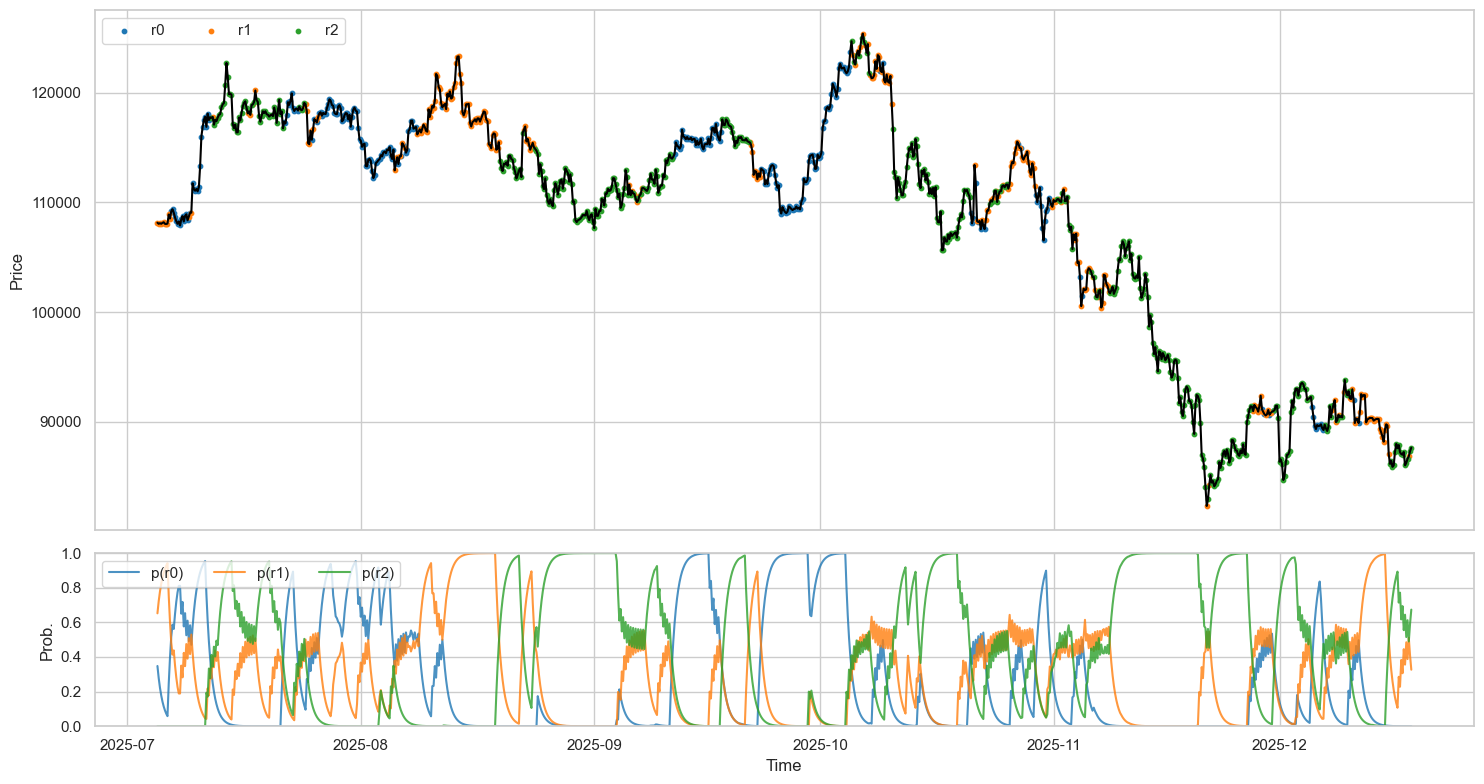

In [17]:
# Plot last 1000 candles for better visibility
subset_slice = slice(-1000, None)
fig, ax = plot_price_with_regimes(
    df_aligned.iloc[subset_slice], 
    df_regimes.iloc[subset_slice], 
    price_col='close',
    figsize=(15, 8)
)
plt.show()

## 4. Regime Statistics
Analyze transition matrices and durations.

In [18]:
stats = compute_regime_stats(features.loc[df_regimes.index], df_regimes)

print("Transition Matrix:")
print(stats['transition_matrix'])

print("\nRegime Durations (Mean):")
print(stats['durations'][['mean_duration', 'max_duration', 'count_runs']])

Transition Matrix:
          r0        r1        r2
r0  0.864968  0.122803  0.012229
r1  0.140294  0.775294  0.084412
r2  0.017755  0.094137  0.888107

Regime Durations (Mean):
    mean_duration  max_duration  count_runs
r0       7.405660           169         530
r1       4.450262           114         764
r2       8.913433            91         335


## 5. Feature Interpretability
What characterizes each regime? We look at the distribution of key features per regime.

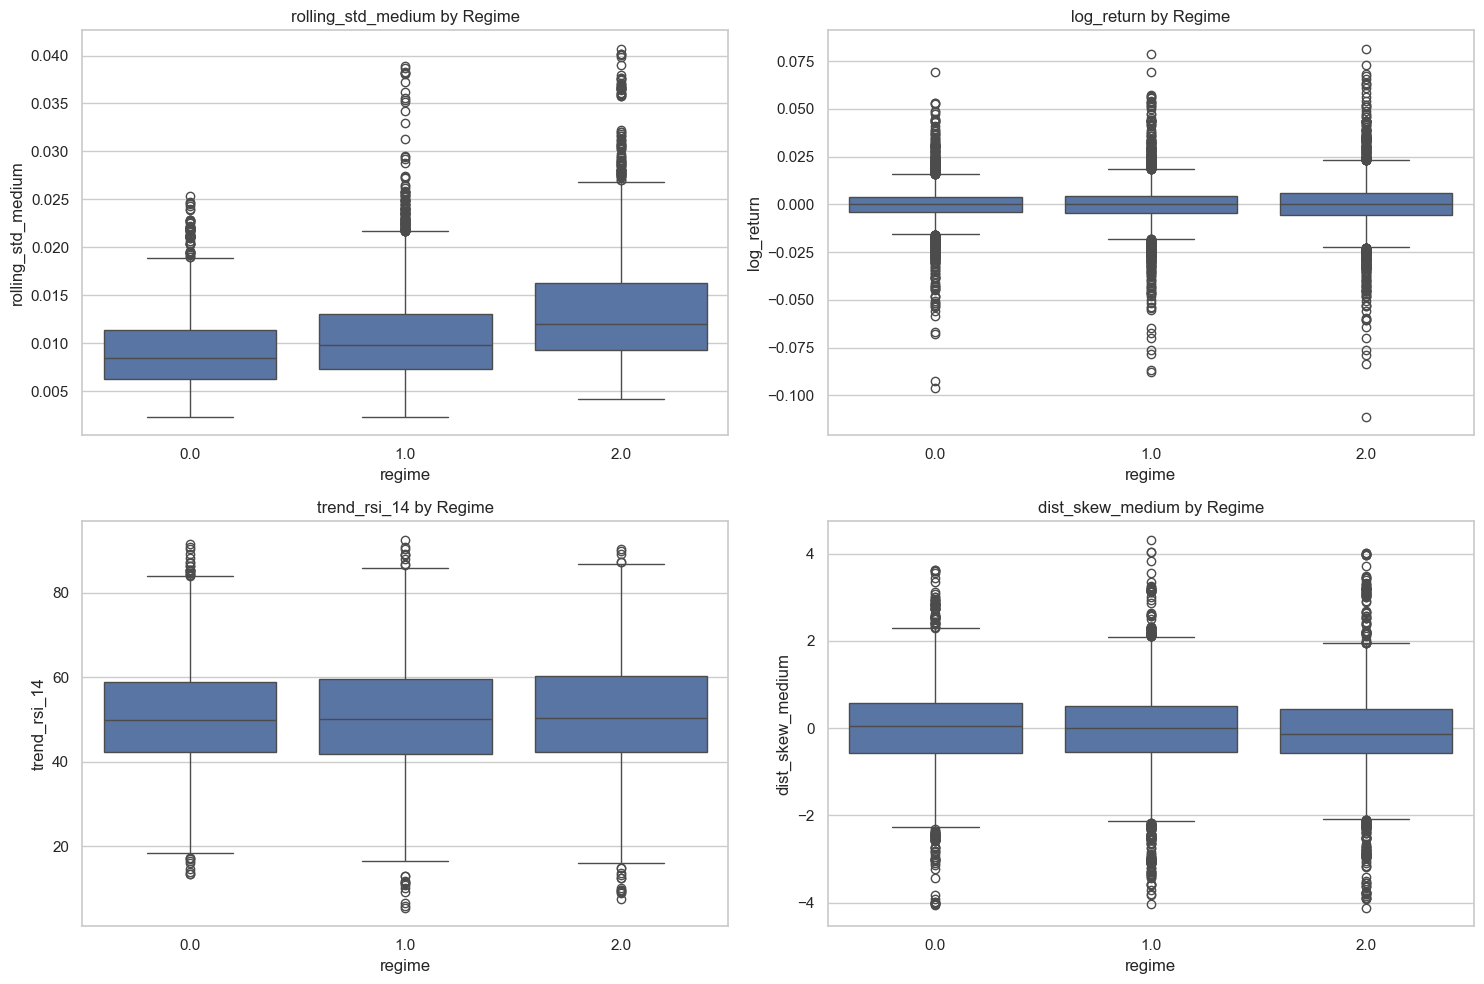

In [19]:
key_features = ['rolling_std_medium', 'log_return', 'trend_rsi_14', 'dist_skew_medium']

plt.figure(figsize=(15, 10))
for i, feat in enumerate(key_features):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x=df_regimes['regime'], y=features.loc[df_regimes.index, feat])
    plt.title(f"{feat} by Regime")
plt.tight_layout()
plt.show()